# Preprocessing - Credit Card Fraud Detection

This notebook shows and explores cleaning the raw dataset explored in the EDA. Engineering features and dropping other features to create a new clean dataset with high use to us for modeling. 

In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_creditcard_data

sns.set(style='whitegrid', palette="viridis")

In [3]:
df = load_creditcard_data()

## Structural Cleanup

First step removes columns that don't contribute meaningful signal and ensures the dataset is in a clean, consistent state before deeper preprocessing. Redundant fields (such as unix_time), ID like columns that can leak identity patterns (such as trans_num), and extremely rare categories are removed to prevent noise and instability during modeling. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [5]:
# Create a list for which columns to drop.
cols_to_drop = ["Unnamed: 0", "cc_num", "first", "last", "zip", "street", "trans_num", "unix_time"]

# Drop the ID like and redundant columns
df = df.drop(columns=cols_to_drop, errors="ignore")

The following columns (Unnamed: 0, cc_num, first, last, street, trans_num) are ID like columns they don't generalize or represent behaviour only identity and thus can cause overfitting. As we saw in the EDA the unix_time feature is redundent with freatures like trans_date_trans_time cause this gives us all the useful information that we need to engineer more temporal features.

## Handle Missing Values

Now we shall look for any missing values in our dataset and determine how these missing values shall be delt with.

In [6]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   merchant               1852394 non-null  object 
 2   category               1852394 non-null  object 
 3   amt                    1852394 non-null  float64
 4   gender                 1852394 non-null  object 
 5   city                   1852394 non-null  object 
 6   state                  1852394 non-null  object 
 7   lat                    1852394 non-null  float64
 8   long                   1852394 non-null  float64
 9   city_pop               1852394 non-null  int64  
 10  job                    1852394 non-null  object 
 11  dob                    1852394 non-null  object 
 12  merch_lat              1852394 non-null  float64
 13  merch_long             1852394 non-null  float64
 14  is_fraud          

Although the dataset at this time contains no missing value, a missing value my occure in future updates to the dataset. There for a missing value handling step is included in the preprocessing pipeline to ensure future compatibility, To prevent failures if new or external data contains unexpected nulls.

In the case of missing Categorical features such as state or jobs the feature should default to 'Unknown'. This helps make sure we can keep the row and allows the model to learn if "missingness" is in itself meaningful. As for numeretical values such as 'amt' then we replace the missing value with the median. This helps preserve the distribution and not distort skewed variables. One set of values tho can cause quite an issue, the geospatial values (i.e. lat, long, merch_lat, merch_long). We can not simply use the mean or zero, as Latitude 0, longitude 0 is in the Atlantic Ocean creating unrealisitc distances. The mean coordinates often land in weird, non-representative places.

Starting with the goespatial features.

In [7]:
latlong_cols = ["lat", "long", "merch_lat", "merch_long"]

# Add missing indicators and impute with median
for col in latlong_cols:
    df[col + '_was_missing'] = df[col].isna().astype(int)
    df[col] = df[col].fillna(df[col].median())

In [8]:
df['trans_date_trans_time_was_missing'] = df['trans_date_trans_time'].isna().astype(int)
df['trans_date_trans_time'] = df['trans_date_trans_time'].fillna(pd.Timestamp("1900-01-01 00:00:00"))

df['dob_was_missing'] = df['dob'].isna().astype(int)
df['dob'] = df['dob'].fillna(pd.Timestamp("1900-01-01"))

A missing transaction timestamp often reflects upstream issues such as incomplete merchant data, degraded authorization paths, or logging failures. Because this missingness can signal unusual or higher‑risk behavior, it’s preserved through a dedicated indicator column. After capturing that signal, the timestamp is imputed with a neutral placeholder value (1900‑01‑01 00:00:00) to maintain a valid datetime structure for downstream feature extraction. This approach keeps the model informed that the original timestamp was unavailable while ensuring the column remains usable for time‑based features.

For the remaining categorical features (merchant, category, gender, city, state, job), any missing entries are replaced with the category "Unknown". This avoids guessing or introducing artificial patterns while still preserving the fact that the original value was unavailable. Treating missingness as its own category keeps the model informed that information was missing and ensures the preprocessing pipeline can continue without discarding potentially useful rows.

In [9]:
cat_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']

# Fill in the missing values
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

For integer and float features, missing values are imputed using the median. The median is a stable, non‑parametric statistic that is resistant to outliers and does not assume any particular distribution. Using it avoids introducing artificial patterns or extreme values that could distort the model. Median imputation keeps the feature on a realistic scale, preserves the overall structure of the data, and ensures the pipeline can continue without discarding rows that may contain valuable fraud‑related signals.

In [10]:
int_cols = ['amt', 'city_pop']

for col in int_cols:
    df[col + '_was_missing'] = df[col].isna().astype(int)
    df[col] = df[col].fillna(df[col].median())

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   trans_date_trans_time              object 
 1   merchant                           object 
 2   category                           object 
 3   amt                                float64
 4   gender                             object 
 5   city                               object 
 6   state                              object 
 7   lat                                float64
 8   long                               float64
 9   city_pop                           int64  
 10  job                                object 
 11  dob                                object 
 12  merch_lat                          float64
 13  merch_long                         float64
 14  is_fraud                           int64  
 15  lat_was_missing                    int32  
 16  long_was_missing  

## Feature Encoding

### Converting Datetime Columns and Extracting Time-Based Features

After handling missing values, the next step is to convert the datetime fields into proper datetime objects so they can be used for feature engineering. Once trans_date_trans_time and dob are in a consistent datetime format, we can extract high‑value temporal features such as transaction hour, day of week, month, and customer age. These features often carry strong fraud signals, since fraudulent activity tends to occur at unusual times or involve atypical customer profiles. Converting the columns at this stage ensures the data is clean, consistent, and ready for downstream modeling.


In [12]:
# Convert to datetime 
df['trans_date_trans_time'] = pd.to_datetime(df["trans_date_trans_time"])
df["dob"] = pd.to_datetime(df["dob"])

# Extract time-based features
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_dayofweek'] = df['trans_date_trans_time'].dt.dayofweek
df['trans_month'] = df['trans_date_trans_time'].dt.month
df['is_night'] = (df['trans_hour'].between(0, 5)).astype(int)

# Customer age
df['age'] = (df['trans_date_trans_time'].dt.year - df['dob'].dt.year)

# Removing the trans_date_trans_time feature.
df = df.drop(columns=['trans_date_trans_time'])
df = df.drop(columns=['dob'])

### Engineering Geospatial Features

The dataset includes latitude and longitude information for both the customer and the merchant, which provides an opportunity to capture meaningful spatial relationships. Raw coordinates are not inherently useful to most machine-learning models, but transforming them into distance based features can reveal strong behavioural patterns. Fraudulent transactions often occur far from a customer's typical location, making geographic distance a valuable signal. By computing the Haversine distance between the customer and merchant coordinates, we convert complex spatial data into a single, interpretable numeric feature that can be used effectively during model training.

In [13]:
# Define the haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371 # Earth radius in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# Create teh distance feature in our dataset

df["distance_km"] = haversine_distance(df["lat"], df["long"], df["merch_lat"], df["merch_long"])

# Drop the lat and long columns
coord_cols = ['lat', 'long', 'merch_lat', 'merch_long']

for col in coord_cols:
    df = df.drop(columns=[col])


### Examining Categorical Features and Applying Frequency Encoding

Before encoding, the categorical features are reviewed to understand their cardinality and distribution. Many fields in this dataset—such as merchant, city, state, and job—contain a large number of unique values. High‑cardinality features can lead to extremely wide one‑hot matrices, increased memory usage, and a higher risk of overfitting. To address this, frequency encoding is applied to these columns, replacing each category with how often it appears in the dataset. This preserves useful information about rarity and commonness while keeping the feature space compact.
The category feature, however, has relatively low cardinality and represents meaningful transaction types. For this column, one‑hot encoding is used instead. This allows the model to learn distinct patterns associated with each transaction category without inflating the feature space


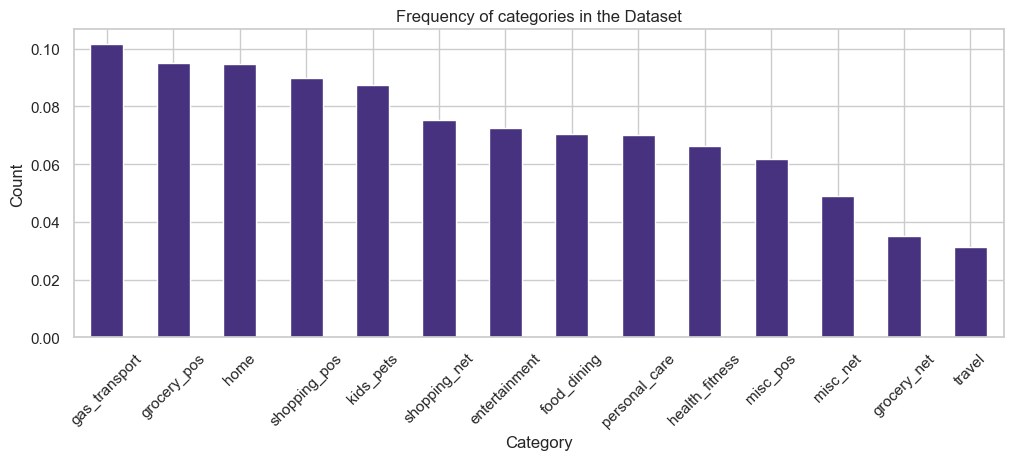

In [14]:
ax = df["category"].value_counts(normalize=True).plot(kind="bar", figsize=(12,4))
ax.set_title("Frequency of categories in the Dataset")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=45)

The category distribution shows that all 14 categories occur at relatively similar frequencies, with none appearing as extreme outliers. Because each category has a substantial presence in the dataset, none of them qualify as “rare” or unstable. This means there’s no need to filter out or collapse any category values at this stage, since each one provides enough data to be reliably modeled. Thus this one we will one-hot encode.

In [15]:
# One-hot encode the 'category' feature
category_dummies = pd.get_dummies(df["category"], prefix="category")

# Add the new columns to the dataframe
df = pd.concat([df, category_dummies], axis=1)

# Drop the original column
df = df.drop(columns=["category"])

# Convert all one-hot encoded category to integer
category_cols = [col for col in df.columns if col.startswith("category_")]
df[category_cols] = df[category_cols].astype(int)

# Replace missing or blank gender values with "Unknown"
df["gender"] = df["gender"].fillna("Unknown")
df["gender"] = df["gender"].replace("", "Unknown")

# Create the dummies
gender_dummies = pd.get_dummies(df["gender"], prefix="gender")
df = pd.concat([df, gender_dummies], axis=1)
df = df.drop(columns=["gender"])

# Finally transforming one-hot columns to integers
gender_cols = [col for col in df.columns if col.startswith("gender_")]
df[gender_cols] = df[gender_cols].astype(int)

In [16]:
df["city"].value_counts(normalize=True)

city
Birmingham     0.004340
San Antonio    0.003947
Utica          0.003946
Phoenix        0.003939
Meridian       0.003935
                 ...   
Chattanooga    0.000004
Karns City     0.000004
Vacaville      0.000004
Streator       0.000004
Wever          0.000003
Name: proportion, Length: 906, dtype: float64

With the city feature containing 906 unique values one-hot encoding would be impractical. Creating hundereds of dummy variables would dramatically increase the dimensionality of the dataset, slow down training, and lead to overfitting as the model memorizes specific city names rather than learning generalizable patterns. In order to keep the important information of the feature without exploding our feature space we use frequency encoding, replacing each city with how often it appears in the dataset. This preserves the important information such as how rare the city is.

In [17]:
# Frequency encoding for the 'city' feature.
city_freq = df["city"].value_counts(normalize=True)
df["city_freq"] = df["city"].map(city_freq)

# Drop the city feature from the dataset
df = df.drop(columns=['city'])

In [18]:
df['merchant'].value_counts(normalize=True)

merchant
fraud_Kilback LLC                        0.003380
fraud_Cormier LLC                        0.002832
fraud_Schumm PLC                         0.002804
fraud_Kuhn LLC                           0.002716
fraud_Boyer PLC                          0.002699
                                           ...   
fraud_Douglas, DuBuque and McKenzie      0.000594
fraud_Treutel-King                       0.000593
fraud_Satterfield-Lowe                   0.000591
fraud_Hahn, Douglas and Schowalter       0.000589
fraud_Ritchie, Bradtke and Stiedemann    0.000588
Name: proportion, Length: 693, dtype: float64

As with the city feature we will use frequency encoding to preserve the feature space well keeping the feature.

In [19]:
# Frequency encoding for the 'merchant' feature
merch_freq = df['merchant'].value_counts(normalize=True)
df['merch_freq'] = df['merchant'].map(merch_freq)

df = df.drop(columns=['merchant'])

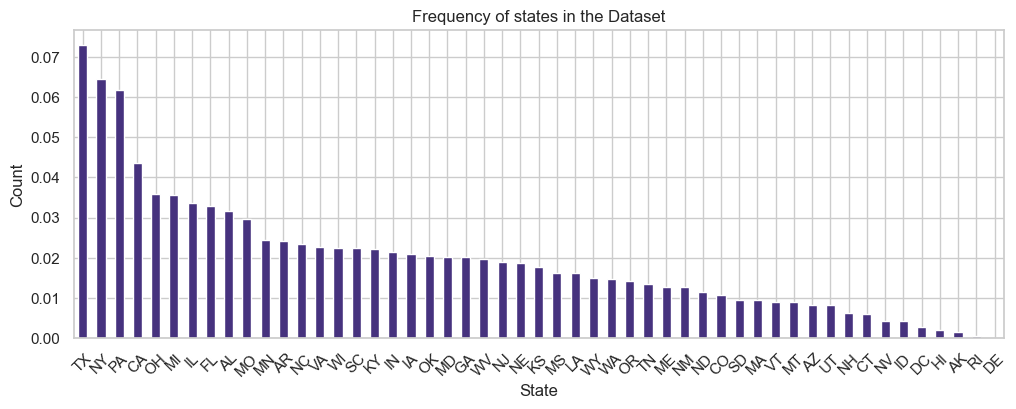

In [20]:
ax = df["state"].value_counts(normalize=True).plot(kind="bar", figsize=(12,4))
ax.set_title("Frequency of states in the Dataset")
ax.set_xlabel("State")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=45)

In [21]:
print("The number of states is ", df['state'].nunique())
df['state'].value_counts()

The number of states is  51


state
TX    135269
NY    119419
PA    114173
CA     80495
OH     66627
MI     65825
IL     62212
FL     60775
AL     58521
MO     54904
MN     45433
AR     44611
NC     43134
VA     41756
WI     41738
SC     41731
KY     40981
IN     39539
IA     38804
OK     38050
MD     37345
GA     37340
WV     36529
NJ     35131
NE     34425
KS     32939
MS     30021
LA     29953
WY     27776
WA     27040
OR     26408
TN     24913
ME     23433
NM     23427
ND     21183
CO     19766
SD     17574
MA     17562
VT     16812
MT     16806
AZ     15362
UT     15357
NH     11727
CT     10979
NV      8058
ID      8035
DC      5130
HI      3649
AK      2963
RI       745
DE         9
Name: count, dtype: int64

The state column contains 51 unique values. This is too many unique values and many of which appear infrequently. Therefore one-hot encoding would create a large number of sparse, low-information columns. To avoid this and keep stability we do as we have done with catogories and merchants and frequency encode the states to perseve the useful signal. 

However before this is done we must address the error discovered during the exploratory data analysis of the state feature. The state DE had a 100% fraud rate with only 9 total transactions. This is signs of an error and with to small of a number of transactions to represent a meaningful pattern. Because all 9 cases are labeled fraud, this creates a misleading signal that the model can exploit as a shortcut rather than learning genuine fraud behavior. To prevent target leakage we will remove the DE transactions from the dataset entirely.

In [22]:
df = df[df['state'] != "DE"].copy()

state_freq = df['state'].value_counts(normalize=True)
df['state_freq'] = df['state'].map(state_freq)

df = df.drop(columns=['state'])

In [23]:
df['job'].value_counts(normalize=True)

job
Film/video editor             0.007503
Exhibition designer           0.007108
Surveyor, land/geomatics      0.006714
Naval architect               0.006712
Materials engineer            0.006322
                                ...   
Veterinary surgeon            0.000004
Engineer, water               0.000004
Contracting civil engineer    0.000004
Ship broker                   0.000004
Warehouse manager             0.000004
Name: proportion, Length: 497, dtype: float64

In [24]:
job_freq = df['job'].value_counts(normalize=True)
df['job_freq'] = df['job'].map(job_freq)

df = df.drop(columns=['job'])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852385 entries, 0 to 1852393
Data columns (total 37 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   amt                                float64
 1   city_pop                           int64  
 2   is_fraud                           int64  
 3   lat_was_missing                    int32  
 4   long_was_missing                   int32  
 5   merch_lat_was_missing              int32  
 6   merch_long_was_missing             int32  
 7   trans_date_trans_time_was_missing  int32  
 8   dob_was_missing                    int32  
 9   amt_was_missing                    int32  
 10  city_pop_was_missing               int32  
 11  trans_hour                         int32  
 12  trans_dayofweek                    int32  
 13  trans_month                        int32  
 14  is_night                           int32  
 15  age                                int32  
 16  distance_km            

## Scaling Numeric Features

With all features now transformed into numeric form—ranging from transaction amounts and engineered time variables to frequency‑encoded categories and geospatial distance—the dataset contains values on very different scales. Large‑magnitude features can dominate model training, especially for algorithms that rely on gradient‑based optimization or distance calculations. To ensure each feature contributes proportionally, the numeric columns are standardized using StandardScaler, which centers each variable around a mean of 0 with unit variance. This approach preserves the underlying distribution of the data, handles outliers more gracefully than range‑based scaling, and is well‑suited for models commonly used in fraud detection such as logistic regression, neural networks, SVMs, and linear classifiers



In [26]:
# Scaling the dataset using standard scale
from sklearn.preprocessing import StandardScaler

numeric_cols = df.select_dtypes(include=["int32","int64", "float64"]).columns

scaler = StandardScaler()

df[numeric_cols]= scaler.fit_transform(df[numeric_cols])

# Moving the target to the end for clarity.
target = df["is_fraud"]
df = df.drop(columns=["is_fraud"])
df["is_fraud"] = target

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852385 entries, 0 to 1852393
Data columns (total 37 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   amt                                float64
 1   city_pop                           float64
 2   lat_was_missing                    float64
 3   long_was_missing                   float64
 4   merch_lat_was_missing              float64
 5   merch_long_was_missing             float64
 6   trans_date_trans_time_was_missing  float64
 7   dob_was_missing                    float64
 8   amt_was_missing                    float64
 9   city_pop_was_missing               float64
 10  trans_hour                         float64
 11  trans_dayofweek                    float64
 12  trans_month                        float64
 13  is_night                           float64
 14  age                                float64
 15  distance_km                        float64
 16  category_entertainment 

## Conclusion

All preprocessing steps are now complete. The dataset has been fully cleaned, engineered, and standardized, including handling missing values, extracting temporal features, computing geospatial distance, encoding categorical variables, generating frequency‑based features, and applying StandardScaler to all numeric columns. The resulting feature matrix is consistent, fully numeric, and ready for model training. With this foundation in place, the next stage is to perform a train–test split and begin evaluating baseline models to establish initial performance benchmarks.
